# Trade off between S, Tmin, and Tmax

In this notebook we investigate the trade off between S, Tmin and Tmax when fitting the log heal model to the data.

2022.04.29 Kurama Okubo

- 2022.04.30 Update using real data of dv/v

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import pickle
import h5py
import emcee # MCMC sampler
import corner
import copy
from scattermatrix import *
from MCMC_func import *

%matplotlib inline

# modules used for Low level callback function duting integration
import os, ctypes
from scipy import integrate, LowLevelCallable
import matplotlib.dates as dates
from matplotlib.gridspec import GridSpec

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 1
plt.rcParams["xtick.minor.visible"] = False # True


plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["ytick.minor.width"] = 1
plt.rcParams["ytick.minor.visible"] = True

os.environ['TZ'] = 'GMT' # change time zone to avoid confusion in unix_tvec conversion

In [2]:
output_imgdir = "../figure"
output_datadir = "../data"

if not os.path.exists(output_imgdir):
    os.makedirs(output_imgdir)
    
if not os.path.exists(output_datadir):
    os.makedirs(output_datadir)

# Process flow
1. Read dv/v data from channel weighted dv/v.

2. Remove the factors of precipitation, temperature and linear trend with maximum likelihood model parameters.

3. Apply MCMC with the tmin.

4. Compare the result to see the trade off.

# 1. Preprocess dv/v data

In [3]:
root = "../../../Post/ModelFit/processed_data/"
h5_stats_list = [root+"02dvvanderr_formodelfit_chanweighted_dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_stretching.csv_0.9-1.2.h5",
                    root+"02dvvanderr_formodelfit_chanweighted_dvvtraces_chanweighted_monitoring_stats_uwbackup_2010-2022_mwcs.csv_0.9-1.2.h5"]

starttime = datetime.datetime(2002, 1, 1)
endtime = datetime.datetime(2022, 6, 1)

refstarttime = datetime.datetime(2010, 1, 1)
refendtime = datetime.datetime(2022, 6, 1)

vlines = [datetime.datetime(2003, 12, 12), datetime.datetime(2004, 9, 28)] 

h5_id = 1 # use mwcs
modelcase = "wlin"

In [4]:
casename = os.path.basename(h5_stats_list[h5_id].split('.h5')[0])
freqband = h5_stats_list[h5_id].split('.h5')[0].split('_')[-1]
dvvmethod = casename.split('.csv')[0].split('_')[-1]


In [5]:
# select target station pair
stationpair = "BP.VCAB-BP.VCAB"

In [6]:
fi = h5py.File(h5_stats_list[h5_id], "r")

In [7]:
uniform_tvec_unix = np.array(fi["uniform_tvec"])
uniform_tvec = np.array([datetime.datetime.fromtimestamp(x) for x in uniform_tvec_unix])
dvv_data = np.array(fi["dvv/{}/dvv".format(stationpair)])
err_data = np.array(fi["dvv/{}/err".format(stationpair)])


In [8]:
# read model parameters
finame = f"../../../Post/ModelFit/modelparam_data/MCMC_modelparam_{stationpair}_{dvvmethod}_{freqband}Hz_{modelcase}.pickle"
with open(finame, "rb") as f:
    modelparam = pickle.load(f)

modelparam["ndim"]


10

In [9]:
# read best fit model paramters
df_param = pd.read_csv(f"../../../Post/ModelFit/data_stats/MCMC_modelparam_all_{dvvmethod}_{freqband}_wlin.csv", index_col=0)
df_pair = df_param.loc[stationpair]
theta_series = df_pair[3:16]
theta_series

a0                -0.04268
p1               -0.006957
a_{precip}         0.03888
p2               -0.001166
t_{shiftdays}    54.524917
S1                0.020048
log10tmin1           4.903
log10tmax1        7.879847
S2                0.042516
log10tmin2           6.993
log10tmax2        8.171853
b_{lin}           0.000009
logf             -3.631456
Name: BP.VCAB-BP.VCAB, dtype: object

In [10]:
# compute dv/v components
dvvmodel, dvvgwl, dvvtemp, dvvhealSS, dvvhealPF, lintrend = model_wlin(theta_series.values, all=True, **modelparam)

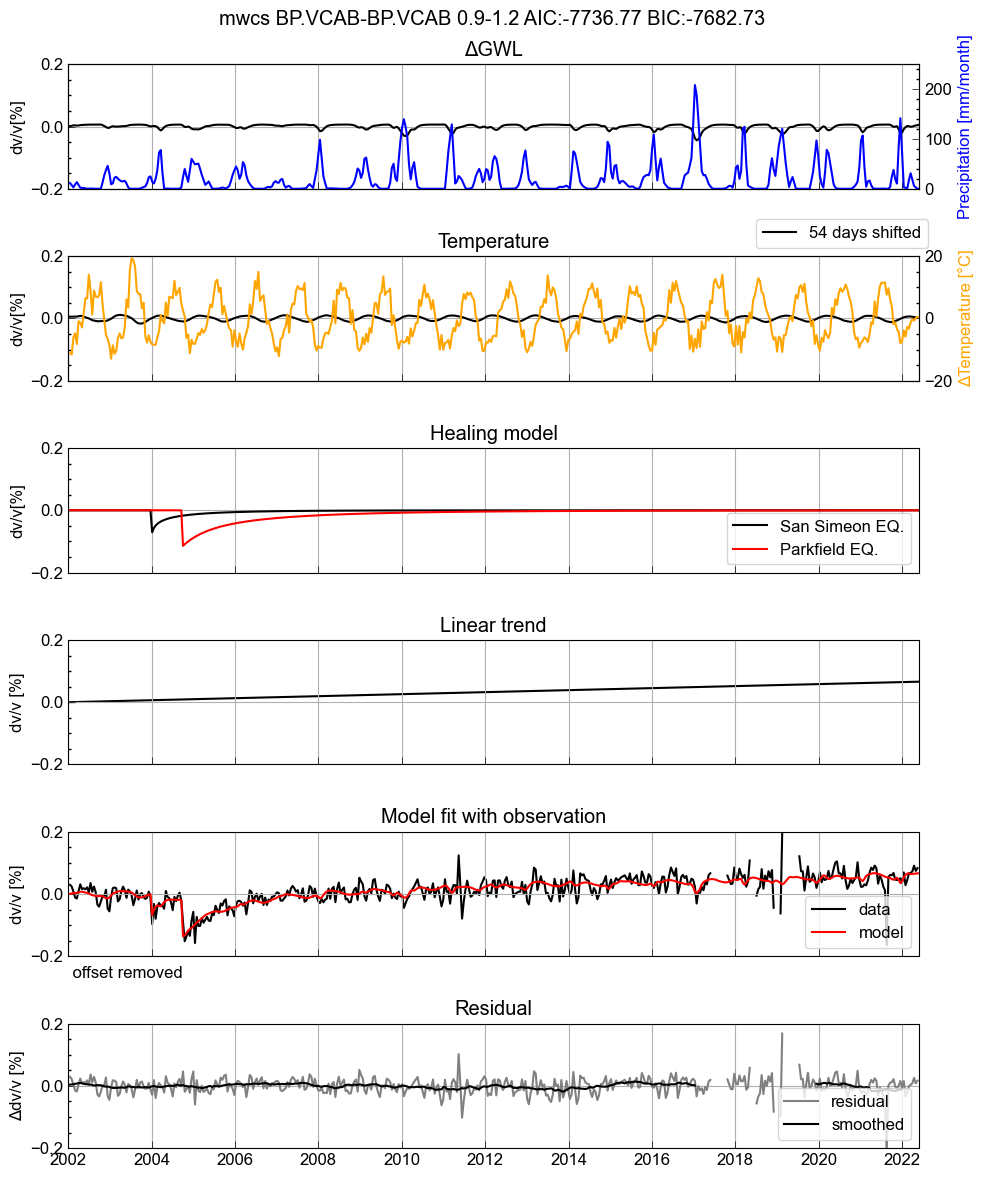

In [11]:
# plot figure
dvvmodel_IsOffsetRemoval = True # remove offset from the dv/v with the periof before San Simeon eq. of the observation
tSS = datetime.datetime(2003, 12, 22) # time for San Simeon
t_shiftdays = theta_series[4]

fig, axs = plt.subplots(6, 1, figsize=(10,12),sharex=True)

# plot GWL
axs[0].plot(uniform_tvec, dvvgwl, "k-")
axs[0].set_title("ΔGWL")
axs[0].set_ylabel("dv/v[%]")

ax02=axs[0].twinx()
# make a plot with different y-axis using second axis object
ax02.plot(uniform_tvec, modelparam["precip"] , color="blue")
ax02.set_ylabel("Precipitation [mm/month]",color="blue")
ax02.set_ylim([0, 250])


# plot Temperature
axs[1].plot(uniform_tvec, dvvtemp, "k-", label="{:2d} days shifted".format(int(t_shiftdays)))
axs[1].set_title("Temperature")
axs[1].set_ylabel("dv/v[%]")

ax12=axs[1].twinx()
# make a plot with different y-axis using second axis object
ax12.plot(uniform_tvec, modelparam["CAVG"] , color="orange")
ax12.set_ylabel("ΔTemperature [°C]",color="orange")
ax12.set_ylim([-20, 20])
axs[1].legend(loc=4, bbox_to_anchor=(1.02, 1.0),)


# plot SS and PF healing
axs[2].plot(uniform_tvec, dvvhealSS, "k-", label="San Simeon EQ.")
axs[2].plot(uniform_tvec, dvvhealPF, "r-", label="Parkfield EQ.")
axs[2].set_title("Healing model")
axs[2].set_ylabel("dv/v[%]")
axs[2].legend(loc=4)

# plot trend
if modelparam["modelcase"] == "base":
    lintrend = np.zeros(len(uniform_tvec)) # plot zero trend for the case of base model
    
axs[3].plot(uniform_tvec, lintrend, ls="-", c = "k", zorder=1)
axs[3].set_title("Linear trend")
axs[3].set_ylabel("dv/v [%]")
# axs[3].legend(loc=4)

# plot dv/v
if dvvmodel_IsOffsetRemoval:
    offset_ind = np.where(np.array(uniform_tvec) < tSS)
    offset_data = np.nanmean(dvv_data[offset_ind])
    dvv_data = dvv_data - offset_data
    dvvmodel = dvvmodel - offset_data
    axs[4].text(starttime, -0.27, " offset removed")
    
# axs[3].errorbar(uniform_tvec, dvv_data, yerr = err_data, capsize=3, ls="-", c = "k", ecolor='black', zorder=1, label="data")
axs[4].plot(uniform_tvec, dvv_data, ls="-", c = "k", zorder=1, label="data")
axs[4].plot(uniform_tvec, dvvmodel, "r-", zorder=2, label="model")
axs[4].set_title("Model fit with observation")
axs[4].set_ylabel("dv/v [%]")
axs[4].legend(loc=4)

# plot residual
axs[5].plot(uniform_tvec, dvv_data-dvvmodel, "-", c="gray", zorder=2, label="residual")
axs[5].plot(uniform_tvec, moving_average(dvv_data-dvvmodel, 20), "k-", zorder=2, label="smoothed")
axs[5].set_title("Residual")
axs[5].set_ylabel("Δdv/v [%]")
axs[5].legend(loc=4)

for i in range(len(axs)):
    axs[i].grid(True)
    axs[i].set_yticks([-0.2, 0.0, 0.2])

plt.setp(axs, xlim=[starttime, endtime])
plt.setp(axs, ylim=[-0.2,0.2])

Nmodelparam = len(theta_series)
AIC_wlin = compute_AIC(dvv_data*1e-2, dvvmodel*1e-2, Nmodelparam) # convert from % to nondim
BIC_wlin = compute_BIC(dvv_data*1e-2, dvvmodel*1e-2, Nmodelparam) # convert from % to nondim

plt.suptitle("{} {} {} AIC:{:4.2f} BIC:{:4.2f}".format(dvvmethod, stationpair, freqband, AIC_wlin, BIC_wlin))

fig.tight_layout()
# vlines = [datetime.datetime(2002, 1, 1), datetime.datetime(2020, 9, 1)] 
# ax.axvline(vlines[0], ls="-", c='b')
# ax.axvline(vlines[1], ls="-", c='b')

foname = (output_imgdir+"/tradeoff_logheal_modelfit_factors_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelparam["modelcase"]))
plt.savefig(foname, dpi=150)

# 2. Remove the dv/v factors associated with precipitation, temperature, and linear trend and Log heal by the San Simeon earthquake.

In [12]:
# remove the
dvv_removalcomp = theta_series["a0"] + dvvgwl + dvvtemp + dvvhealSS + lintrend # components to be removed

if dvvmodel_IsOffsetRemoval:
#     offset_ind = np.where(np.array(uniform_tvec) < tSS)
#     offset_data = np.nanmean(dvv_data[offset_ind])
    dvv_removalcomp = dvv_removalcomp - offset_data
    
dvv_data_PF = dvv_data - dvv_removalcomp

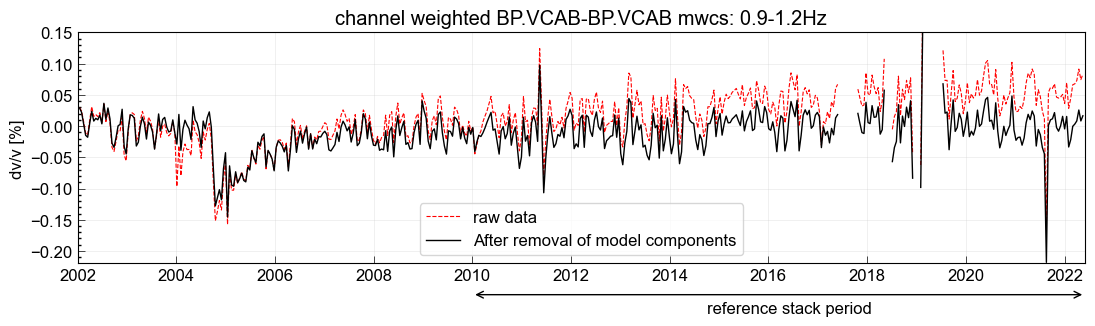

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(13,3))

ax.plot(uniform_tvec, dvv_data, "r--", lw=0.8, label="raw data")
ax.plot(uniform_tvec, dvv_data_PF, "k-", lw=1, label="After removal of model components")


xfmt = dates.DateFormatter('%Y')

ax.set_ylim(-0.22, 0.15)
ax.set_yticks(np.linspace(-0.20, 0.15, 8))
ax.set_ylabel("dv/v [%]")
ax.set_xlim(starttime, endtime)
ax.grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)

# annotate reference period
refy = -0.27
ax.annotate('', xy=(refstarttime, refy), xytext=(refendtime, refy), arrowprops=dict(arrowstyle='<->'), annotation_clip=False)
ax.text(datetime.datetime(2016,6,1), -0.28, "reference stack period", ha="center", va='top')
# axs[1].plot([refstarttime, refendtime], [-0.3, -0.3], clip_on=False,)

ax.set_title(f"channel weighted {stationpair} {dvvmethod}: {freqband}Hz")
ax.legend(loc=8)

foname = (output_imgdir+"/tradeoff_logheal_dvvafterremovalfactors_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelparam["modelcase"]))
plt.savefig(foname, dpi=150, bbox_inches='tight')

In [14]:
# Save data for master plot
masterplot_data = dict(stationpair=stationpair, dvvmethod=dvvmethod, freqband=freqband, modelcase=modelparam["modelcase"],
                                   uniform_tvec=uniform_tvec, unix_tvec=modelparam["unix_tvec"], unix_SS=modelparam["unix_tSS"], unix_tPF=modelparam["unix_tPF"],
                                   dvv_data=dvv_data, dvv_data_PF = dvv_data_PF,
                                   )


In [15]:
# define the fitting period
xliimit_focus = [datetime.datetime(2003, 1, 1), datetime.datetime(2010, 1, 1)]
fitting_period_ind = np.where((uniform_tvec >= xliimit_focus[0]) & (uniform_tvec <= xliimit_focus[1]))

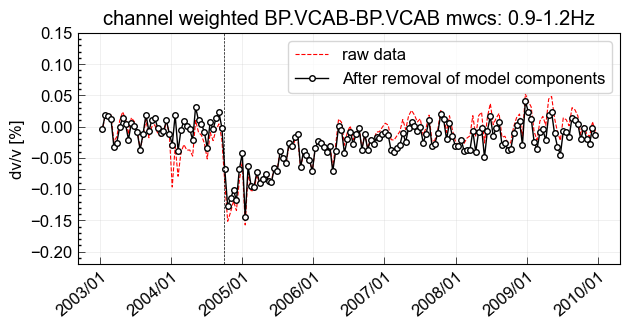

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))

ax.plot(uniform_tvec[fitting_period_ind], dvv_data[fitting_period_ind], "r--", lw=0.8, label="raw data")
ax.plot(uniform_tvec[fitting_period_ind], dvv_data_PF[fitting_period_ind], "ko-", lw=1, markerfacecolor="w", ms=4, label="After removal of model components")


ax.set_ylim(-0.22, 0.15)
ax.set_yticks(np.linspace(-0.20, 0.15, 8))
ax.set_ylabel("dv/v [%]")
# ax.set_xlim(xliimit_focus)
ax.grid(True, axis="both", lw=0.5, c=[0.8, 0.8, 0.8], alpha=0.4, zorder=-20)

ax.axvline(vlines[1], color='k', linewidth=0.5, linestyle='--', zorder=2)
ax.set_title(f"channel weighted {stationpair} {dvvmethod}: {freqband}Hz")
ax.legend(loc=1)

xfmt = dates.DateFormatter('%Y/%m')
ax.xaxis.set_major_formatter(xfmt) 
plt.setp(ax.get_xticklabels(), rotation=40, ha="right", rotation_mode="anchor")

foname = (output_imgdir+"/tradeoff_logheal_dvvafterremovalfactors_focus_{}_{}_{}_{}.png".format(stationpair, dvvmethod, freqband, modelparam["modelcase"]))
plt.savefig(foname, dpi=150, bbox_inches='tight')

In [17]:
# Save data for master plot
masterplot_data["xliimit_focus"] = xliimit_focus
masterplot_data["fitting_period_ind"] = fitting_period_ind

# Apply MCMC inversion with tmin

In [18]:
# Integration with low level callback function
# read shared library
lib_int = ctypes.CDLL(os.path.abspath('./LowLevel_callback_healing_distributed/healing_int.so'))
lib_int.f.restype = ctypes.c_double
lib_int.f.argtypes = (ctypes.c_int, ctypes.POINTER(ctypes.c_double), ctypes.c_void_p)
    
def logheal_llc(ts, S, taumin, taumax, lib_int):
    # using Low-level caling function
    # taumin = 0.1 # fix taumin so that healing starts just after incident
    c = ctypes.c_double(ts) # time t as void * userdata
    user_data = ctypes.cast(ctypes.pointer(c), ctypes.c_void_p)
    int1_llc = LowLevelCallable(lib_int.f, user_data) # in this way, only void* is available as argument

    return -S*integrate.quad(int1_llc, taumin, taumax, epsabs = 1e-3, epsrel=1e-3)[0] # this tolerance archieves our requirement in accuracy.

def y_heal_llc(t, S, taumin, taumax, unix_tEV, lib_int):
    if t < unix_tEV:
        return 0
    else:
        # compute logheal model
        return logheal_llc(t-unix_tEV, S, taumin, taumax, lib_int)

In [19]:
# overwrite dvv_data and err data with fitting period
modelparam_fit = copy.deepcopy(modelparam)
modelparam_fit["xliimit_focus"] = xliimit_focus
modelparam_fit["fitting_period_ind"] = fitting_period_ind
modelparam_fit["unix_tvec"] = modelparam["unix_tvec"][fitting_period_ind]
modelparam_fit["uniform_tvec"] = uniform_tvec[fitting_period_ind]
modelparam_fit["dvv_data"] = dvv_data[fitting_period_ind]
modelparam_fit["err_data"] = err_data[fitting_period_ind]

In [20]:
modelparam_fit["unix_tPF"]

1096329600

In [21]:
# Apply constraint
S_range = [0, 0.6]
tmin_range = [1e-3, 1.0] # years
tmax_range = [0.7, 100] #[2, 100] # years

#---Log probabilities---#
def log_likelihood_PF(theta, **modelparam):
    #parse parameters
    S, tmin, tmax, log_f = theta
    unix_tvec = modelparam["unix_tvec"]
    uniform_tvec = modelparam["uniform_tvec"]
    dvv_model= [y_heal_llc(t, S, 10**tmin, 10**tmax, modelparam["unix_tPF"], lib_int) for t in unix_tvec]

    dvv_data = modelparam["dvv_data"]
    err_data  = modelparam["err_data"]
    
    # sigma2 = yerr_trim ** 2 + model ** 2 * np.exp(2 * log_f)
    sigma2 = err_data ** 2 + np.exp(2 * log_f) # 2022.2.21 Applying constant over/under estimation in error

#     #debug plot
#     plt.plot(uniform_tvec, dvv_data, "k-x", label = "data")
#     plt.plot(uniform_tvec, dvv_model, "r-o", label = "model")
#     plt.legend(loc=1)
#     plt.title(f"residu: {np.linalg.norm(dvv_data - dvv_model):.8f}")
    
    return -0.5 * np.nansum((dvv_data - dvv_model) ** 2 / sigma2 + np.log(sigma2)) # 2pi is ignored

# assign boundary of parammeters as prior probability
def log_prior_PF(theta, **modelparam):

    S, logtmin, logtmax, log_f = theta

    tmin = 10**logtmin
    tmax = 10**logtmax
    tmin_range_sec = np.array(tmin_range) *365*86400
    tmax_range_sec = np.array(tmax_range) *365*86400

    if (S<S_range[0]) or (S_range[1] < S): # We constrain 0<S<1.0 to avoid the large trade off between S, tmin and tmax
        return -np.inf
    
    if (tmin<tmin_range_sec[0]) or (tmin_range_sec[1] < tmin):
        return -np.inf
    
    if (tmax<tmax_range_sec[0]) or (tmax_range_sec[1] < tmax):
        return -np.inf
    
    if (tmin>tmax):
        return -np.inf
    
    if (-10.0 > log_f) or (log_f > -1.0):
        return -np.inf
    
    # if all the trial parameters are within the boundaries, return 0.
    return 0

def log_probability_PF(theta0, **modelparam):
    if len(theta0)==3:
        theta=np.concatenate((theta0[0], modelparam["tmin_fixed"], theta0[1:4]), axis=None)
    elif len(theta0)==4:
        theta = theta0 
    else:
        theta = theta0
    
    lp = log_prior_PF(theta, **modelparam)

    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood_PF(theta, **modelparam)


## Configure the MCMC paramters

In [22]:
#---parameters for MCMC---#
modelparam_fit["nwalkers"] = 16
modelparam_fit["nsteps"] = 10000
mcmc_discard_nsample = 2000

# We assign the initial value around the maximum likelihood paramters
S_init = 0.06
log10tmin_init= 7.0 # fix vmin with the value used for MCMC
log10tmax_init= 8.0 # fix vmin with the value used for MCMC
logf_init= -3.5 # fix vmin with the value used for MCMC

caseid = 1 # case0: fix tmin case1: including tmin
#-------------------------------------#

if caseid == 0:
    modelparam_fit["ndim"] = 3
    modelparam_fit["tmin_fixed"] = log10tmin_init
    modelparam_fit["pos"] =  np.array([S_init, log10tmax_init, logf_init]) + 1e-4 * np.random.randn(modelparam_fit["nwalkers"], modelparam_fit["ndim"])
        
elif caseid == 1:
    modelparam_fit["ndim"] = 4
    modelparam_fit["pos"] =  np.array([S_init, log10tmin_init, log10tmax_init, logf_init]) + 1e-4 * np.random.randn(modelparam_fit["nwalkers"], modelparam_fit["ndim"])


In [23]:
modelparam_fit["pos"][1, :]

array([ 0.05994672,  7.00001022,  7.9999285 , -3.50001244])

In [24]:
# test log_probability
log_probability_PF(modelparam_fit["pos"][0, :], **modelparam_fit)

538.4707162172456

In [25]:
np.random.seed(seed=20230501)

sampler = emcee.EnsembleSampler(
                modelparam_fit["nwalkers"], modelparam_fit["ndim"], log_probability_PF,
                moves=[#emcee.moves.StretchMove(),
                            (emcee.moves.DEMove(), 0.8),
                            (emcee.moves.DESnookerMove(), 0.2),
                            ],
                kwargs=(modelparam_fit))

start = time.time()
sampler.run_mcmc(modelparam_fit["pos"], modelparam_fit["nsteps"], progress=True)
end = time.time()
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))


100%|█████████████████████████████████████| 10000/10000 [04:13<00:00, 39.50it/s]

Multiprocessing took 253.2 seconds


## Check autocorrelation time

In [26]:
autocorr = emcee.autocorr.integrated_time(sampler.get_chain())
autocorr * 50

array([7246.6772704 , 8418.61653319, 7197.96671136, 2363.7691594 ])

## Plot result

In [27]:
def rescale_chain(chain, caseid):
    """
    rescale time
    """
    if  len(chain.shape)==3:
        # chains are not flatten
        #log10time[s] -> log10time[year]
        if caseid==0:
            chain[:, :, 1] = np.log10(np.array([10**x/86400/365 for x in chain[:, :, 1]]))
        else:
            chain[:, :, 1] = np.log10(np.array([10**x/86400/365 for x in chain[:, :, 1]]))
            chain[:, :, 2] = np.log10(np.array([10**x/86400/365 for x in chain[:, :, 2]]))
        
    elif len(chain.shape)==2:
        # chains are flattern
        if caseid==0:
            chain[:, 1] = np.log10(np.array([10**x/86400/365 for x in chain[:, 1]]))
        else:
            chain[:, 1] = np.log10(np.array([10**x/86400/365 for x in chain[:, 1]]))
            chain[:, 2] = np.log10(np.array([10**x/86400/365 for x in chain[:, 2]]))
    else:
        raise ValueError("size of chain is unknown.") 

def rescale_theta(theta, caseid):
    if caseid==0:
        theta[1] = np.log10(10**theta[1]/86400/365)
    elif caseid==1:
        theta[1] = np.log10(10**theta[1]/86400/365)
        theta[2] = np.log10(10**theta[2]/86400/365)

In [28]:
# get the chains of samples separately
chains_samples = sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=False)

# get the chains of log probability
chains_lnprob =  sampler.get_log_prob(discard=mcmc_discard_nsample, thin=1, flat=False)

# select the chain id with the maximum log probability among the chains
chains_lnprobmaxarg = np.argmax(chains_lnprob, axis=0)

# extract the single chain of log probability with its maximum
chains_lnprobmax = np.array([chains_lnprob[x, i] for i, x in enumerate(chains_lnprobmaxarg)])

# compare the maximum log probability with different chains and get the best chain id
lnprob_maxchain_id = np.argmax(chains_lnprobmax)

# extract the best chain of samples
flat_samples_maxprob = chains_samples[:, lnprob_maxchain_id, :]

# obtain the model parameters with the best log probability
maxlnprob_theta = copy.deepcopy(flat_samples_maxprob[chains_lnprobmaxarg[lnprob_maxchain_id], :])
rescale_theta(maxlnprob_theta, caseid) # rescale t and blin

In [29]:
modelparam["caseid"] = caseid
modelparam["maxlnprob_theta"] = flat_samples_maxprob[chains_lnprobmaxarg[lnprob_maxchain_id], :]

# Save the current state.
foname = f"{output_datadir}/tradeoff_Sandtmintmax_{stationpair}_{dvvmethod}_{freqband}_{modelparam_fit['modelcase']}_{caseid}_{modelparam_fit['nsteps']}.pickle"

with open(foname, "wb") as f:
    pickle.dump(sampler, f)
    pickle.dump(modelparam, f)

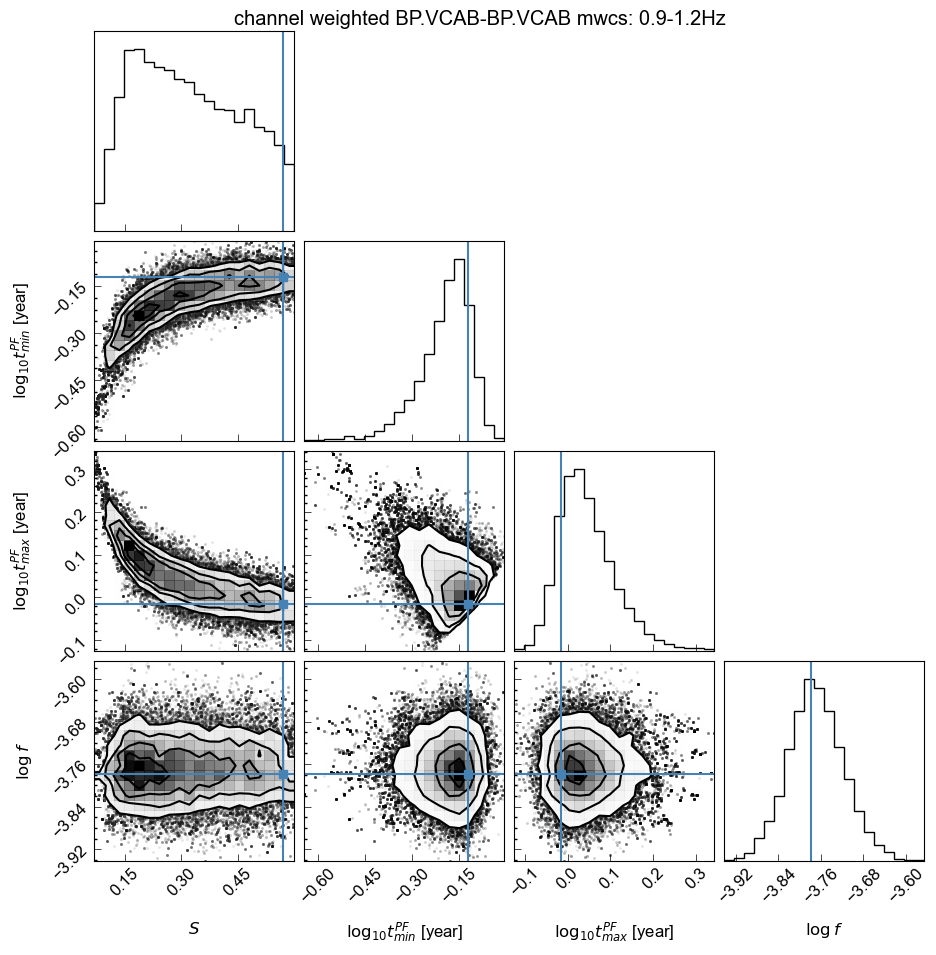

In [30]:
# Plot using corner.corner
# Reference: Foreman-Mackey (2016) https://corner.readthedocs.io/en/latest/
chains_samples_all = copy.deepcopy(sampler.get_chain(discard=mcmc_discard_nsample, thin=1, flat=True))
rescale_chain(chains_samples_all, caseid)

if caseid==0:
    labels = ["$S$", "$\log_{10} t_{max}^{PF}$ [year]", "$\log{f}$"]
    
elif caseid==1:
    labels = ["$S$", "$\log_{10} t_{min}^{PF}$ [year]", "$\log_{10} t_{max}^{PF}$ [year]", "$\log{f}$"]

    
fig = corner.corner(
    chains_samples_all, labels=labels, truths=maxlnprob_theta);

fig.suptitle(f'channel weighted {stationpair} {dvvmethod}: {freqband}Hz')
foname = (output_imgdir+f"/MCMC_tradeoff_Sandtmintmax_cornerplot_{stationpair}_{dvvmethod}_{freqband}_{modelparam['modelcase']}_{caseid}_{modelparam['nsteps']}.png")
plt.savefig(foname, dpi=300, bbox_inches='tight')

In [31]:
# Read ranges and ticks from corner plot
if caseid == 0:
    cornerticks_x_inds =np.arange(6, 9) # axes number of lower rows for x ticks
    cornerticks_y_inds =np.arange(3, 9, 3)# axes number of lower rows for y ticks
elif caseid == 1:
    cornerticks_x_inds =np.arange(12, 16) # axes number of lower rows for x ticks
    cornerticks_y_inds =np.arange(4, 16, 4)# axes number of lower rows for y ticks

cornerranges_x = []
cornerranges_y = []
cornerticks_x = []
cornerticks_y = []

for i in cornerticks_x_inds:
    cornerranges_x.append(list(fig.axes[i].get_xlim()))
    cornerticks_x.append([np.round(x.get_unitless_position()[0], 10) for x in fig.axes[i].get_xticklabels()[:-1]])
for j in cornerticks_y_inds:
    cornerranges_y.append(list(fig.axes[j].get_ylim()))
    cornerticks_y.append([np.round(y.get_unitless_position()[1], 10) for y in fig.axes[j].get_yticklabels()[:-1]])

print(cornerranges_x, cornerranges_y)
print(cornerticks_x, cornerticks_y)

[[0.06900137294730704, 0.5999987009576592], [-0.6417124346115355, -0.005899066352123371], [-0.12476233666581148, 0.3435541046805682], [-3.941423017194287, -3.5655203789296612]] [[-0.6417124346115355, -0.005899066352123371], [-0.12476233666581148, 0.3435541046805682], [-3.941423017194287, -3.5655203789296612]]
[[0.15, 0.3, 0.45], [-0.6, -0.45, -0.3, -0.15], [-0.1, 0.0, 0.1, 0.2, 0.3], [-3.92, -3.84, -3.76, -3.68, -3.6]] [[-0.6, -0.45, -0.3, -0.15], [-0.1, 0.0, 0.1, 0.2, 0.3], [-3.92, -3.84, -3.76, -3.68, -3.6]]


In [32]:
datainds_trim = range(len(labels[:-1]))  #[0, 1, 2] #range(len(labels[:-1])) # plot all quantities
labels_trim=[labels[x] for x in datainds_trim]

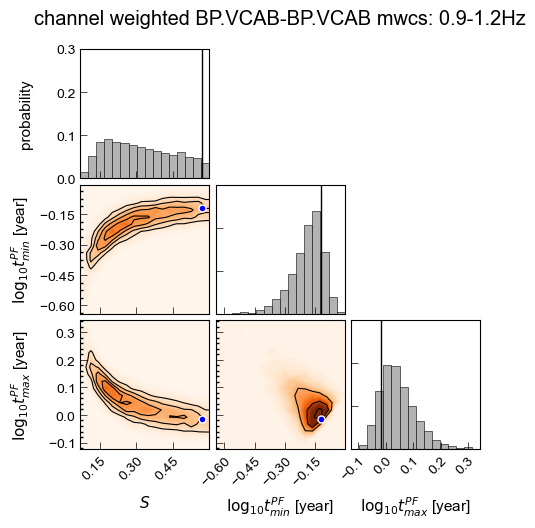

In [33]:
modelparam["nbin_hist"] = 16


# flat_samples_maxprob

fig0, axs, sm = plot_scattermatrix(chains_samples_all, datainds_trim, labels_trim, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05,
    xrange_sigma_factor=2, bincolorgray=0.7, nbin_hist=modelparam["nbin_hist"], nbin_hist2d=18, Ncontourf=51, Ncontour=5, Ncontour_clip=4, cmap="Oranges",
    xticks=cornerticks_x, yticks=cornerticks_y, plot_truth=True,
    ylim_max=0.3, zlim_max=0.04, xranges=cornerranges_x, plot_median=False, plot_bestparam=maxlnprob_theta, labelfontsize=11, tickfontsize=10, figsize=(5, 5));

fig0.align_labels();

fig0.suptitle(f'channel weighted {stationpair} {dvvmethod}: {freqband}Hz')
# plt.subplots_adjust(top=0.9)

foname = (output_imgdir+f"/MCMC_tradeoff_Sandtmintmax_scattermatrix_{stationpair}_{dvvmethod}_{freqband}_{modelparam['modelcase']}_{caseid}_{modelparam['nsteps']}.png")
plt.savefig(foname, dpi=150, bbox_inches='tight')

In [34]:
lc = mpl.cm.Set2_r(np.linspace(0,1,sampler.nwalkers))
xmax = modelparam_fit["nsteps"]+500

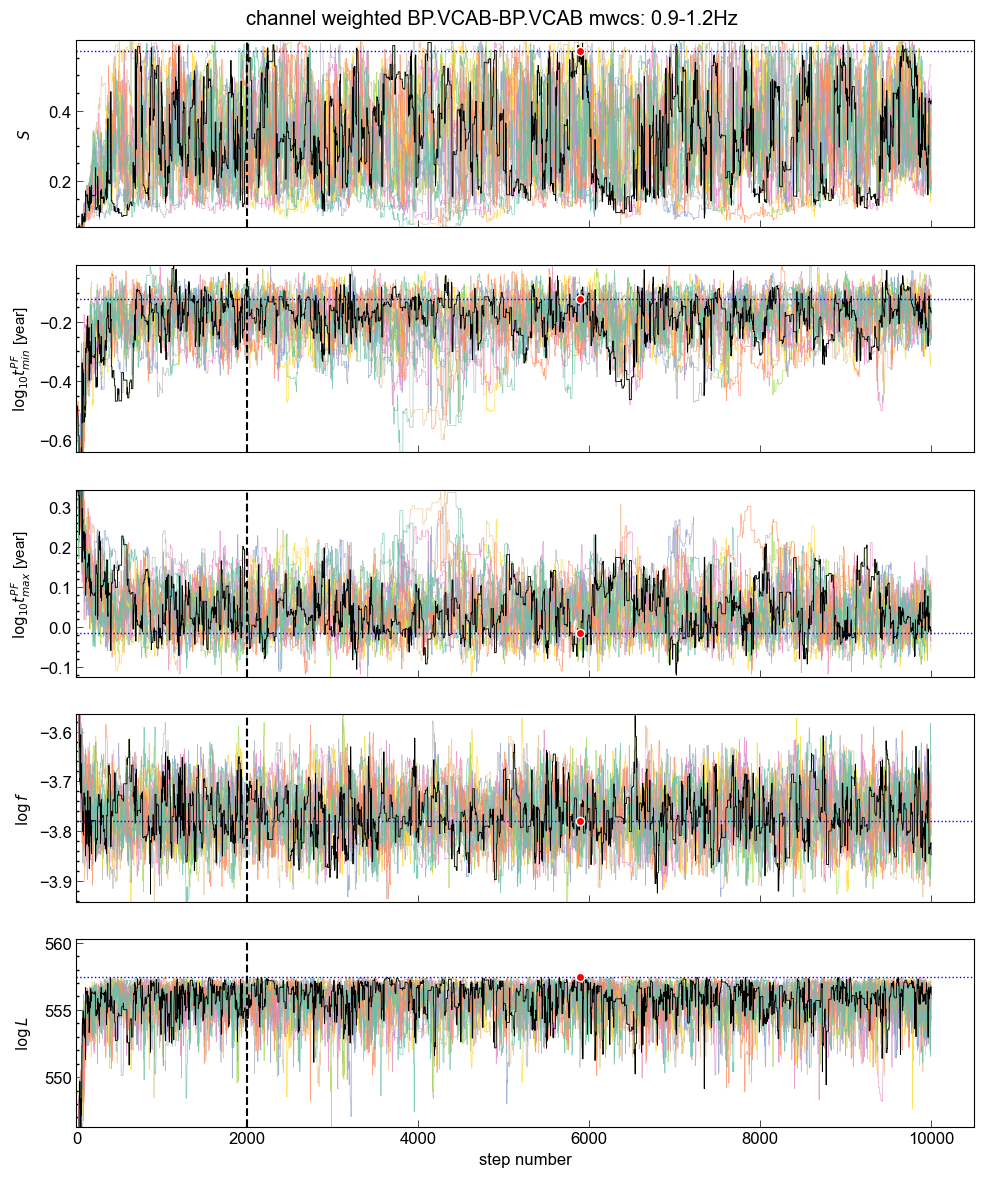

In [35]:
chain_log_prob_plot = sampler.get_log_prob(discard=0, thin=1, flat=False) # retrieve all the log prob history
max_logprob_ind = chains_lnprobmaxarg[lnprob_maxchain_id] # plot the iteration of max log prob

samples = copy.deepcopy(sampler.get_chain(discard=0, thin=1, flat=False)) # retrieve all the samples with separate chain
rescale_chain(samples, caseid)

fig, axes = plt.subplots(sampler.ndim+1, figsize=(10, 12), sharex=True)
lw_maxprob = 0.6

labelfontsize = 10.8

# append the limit of log prob
ylim_list = copy.deepcopy(cornerranges_x)
maxprobval = chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id]
ylim_list.append([0.98*maxprobval, 1.005*maxprobval])

for i in range(sampler.ndim):
    ax = axes[i]
    
    for j in range(sampler.nwalkers):
        ax.plot(samples[:, j, i], lw=0.5, c=lc[j, :], alpha=0.8)
        
    # plot the chain with maximum log probability
    ax.plot(samples[:, lnprob_maxchain_id, i], c="k", lw=lw_maxprob) 
    
    ax.set_xlim([0, xmax])
    ax.set_ylim(ylim_list[i])
    ax.set_ylabel(labels[i], fontsize=labelfontsize)
#     ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axvline(mcmc_discard_nsample, c="k", ls="--")
    # plot maximum likelihood parameters
    ax.axhline(maxlnprob_theta[i], c="b", ls=":", lw=1.0)
    ax.plot(max_logprob_ind+mcmc_discard_nsample, maxlnprob_theta[i], "ro", ms=6, markeredgecolor="w");

# plot maximum log probability
plot_logprob = chain_log_prob_plot[:, lnprob_maxchain_id]

ax = axes[-1]
for i in range(chain_log_prob_plot.shape[1]):
    ax.plot(chain_log_prob_plot[:, i], lw=0.5, c=lc[i, :], alpha=0.8);

ax.axvline(mcmc_discard_nsample, c="k", ls="--")
# plot the chain with maximum log probability
ax.plot(plot_logprob, c="k", lw=lw_maxprob)
ax.axhline(chain_log_prob_plot[max_logprob_ind+mcmc_discard_nsample, lnprob_maxchain_id], c="b", ls=":", lw=1.0)
ax.plot(max_logprob_ind+mcmc_discard_nsample, maxprobval, "ro", ms=6, markeredgecolor="w");

ax.set_xlim([0, xmax])
ax.set_ylim(ylim_list[-1])
ax.set_ylabel("$\log{L}$", fontsize=labelfontsize)

axes[-1].set_xlabel("step number");
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)

foname = (output_imgdir+f"/MCMC_tradeoff_Sandtmintmax_allchains_{stationpair}_{dvvmethod}_{freqband}_{modelparam['modelcase']}_{caseid}_{modelparam['nsteps']}.png")

fig.suptitle(f'channel weighted {stationpair} {dvvmethod}: {freqband}Hz')
fig.tight_layout(rect=[0,0,1,1])
plt.subplots_adjust(hspace=0.2)
fig.align_ylabels()

plt.savefig(foname, dpi=150, bbox_inches='tight')

# Save data for master plot

In [36]:
masterplot_data["mcmc_discard_nsample"] = mcmc_discard_nsample
masterplot_data["labels"] = labels
masterplot_data["S_range"] = S_range
masterplot_data["tmin_range"] = tmin_range
masterplot_data["tmax_range"] = tmax_range
masterplot_data["cornerranges_x"] = cornerranges_x
masterplot_data["cornerranges_y"] = cornerranges_y
masterplot_data["cornerticks_x"] = cornerticks_x
masterplot_data["cornerticks_y"] = cornerticks_y

# Save the current state.
foname = f"{output_datadir}/tradeoff_Sandtmintmax_masterdata_{stationpair}_{dvvmethod}_{freqband}_{modelparam_fit['modelcase']}_{caseid}_{modelparam_fit['nsteps']}.pickle"

with open(foname, "wb") as f:
    pickle.dump(sampler, f)
    pickle.dump(masterplot_data, f)

In [37]:
masterplot_data.keys()

dict_keys(['stationpair', 'dvvmethod', 'freqband', 'modelcase', 'uniform_tvec', 'unix_tvec', 'unix_SS', 'unix_tPF', 'dvv_data', 'dvv_data_PF', 'xliimit_focus', 'fitting_period_ind', 'mcmc_discard_nsample', 'labels', 'S_range', 'tmin_range', 'tmax_range', 'cornerranges_x', 'cornerranges_y', 'cornerticks_x', 'cornerticks_y'])